## Anomaly detection with autoencoders

In this notebook we you have to create a fully-connected neural network based autoencoder in order to detect credit card frauds. In the dataset there are 492 labeled frauds and 284807 normal transactions. First, let's download the dataset and unpack it (original source of the dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud - before downloading the data please read and accept the licence of the original datasource):

In [1]:
!wget https://www.deeplearningoktatas.hu/downloads/Anomaly/creditcardfraud.zip

--2023-05-10 05:49:12--  https://www.deeplearningoktatas.hu/downloads/Anomaly/creditcardfraud.zip
Resolving www.deeplearningoktatas.hu (www.deeplearningoktatas.hu)... 91.227.138.51
Connecting to www.deeplearningoktatas.hu (www.deeplearningoktatas.hu)|91.227.138.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69155632 (66M) [application/zip]
Saving to: ‘creditcardfraud.zip’

creditcardfraud.zip 100%[===================>]  65.95M  18.5MB/s    in 3.8s    

2023-05-10 05:49:17 (17.3 MB/s) - ‘creditcardfraud.zip’ saved [69155632/69155632]



In [2]:
%%capture
!unzip creditcardfraud.zip

## Imports
Import the necessary modules:

In [3]:
import pandas as pd # 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from sklearn import preprocessing 
from sklearn.metrics import mean_squared_error
np.random.seed(123)

## Exercise 1: Reading and preparing the data
Read the creditcard.csv into a Pandas Dataframe with the [read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html) function. 

In [4]:
df = pd.read_csv('creditcard.csv')
df.head()

## Note: The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
## Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As the next step, select all the columns of the dataframe for the input X, but the "Class" column. And select the "Class" column for output Y. Make sure that both X and Y are two dimensional Numpy arrays. 

Hint:
* you can use df.loc to select rows and columns from a dataframe
* you can get the Numpy array of a Pandas object with .values, eg. df['myfeature'].values

In [5]:
cols = df.columns.to_list()
cols.remove('Class')

In [6]:
X = df.loc[:, cols].values
Y = df.loc[:, 'Class'].values

In [7]:
print("Shape of X:",X.shape)
print("Shape of Y:",Y.shape)
print('Frauds:', np.count_nonzero(Y == 1))

Shape of X: (284807, 30)
Shape of Y: (284807,)
Frauds: 492


Let's standardize the data:

In [8]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

## Exercise 2: defining the autoencoder
Let's define a model according to the following instructions:
* the model's inputs and outputs should be the same as the number of X's features (columns)
* the model should have 5 hidden layers, with 16-10-6-10-16 neurons in the hidden layers, respectively
* all layers but the output should have tanh activation
* the output layer should have linear activation

In [9]:
X.shape[1]

30

In [60]:
model = Sequential()
model.add(Dense(16, activation='tanh', input_shape=(X.shape[1],)))
model.add(Dense(10, activation='tanh'))
model.add(Dense(6, activation='tanh'))
model.add(Dense(10, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(X.shape[1], activation='linear'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 16)                496       
                                                                 
 dense_38 (Dense)            (None, 10)                170       
                                                                 
 dense_39 (Dense)            (None, 6)                 66        
                                                                 
 dense_40 (Dense)            (None, 10)                70        
                                                                 
 dense_41 (Dense)            (None, 16)                176       
                                                                 
 dense_42 (Dense)            (None, 30)                510       
                                                                 
Total params: 1,488
Trainable params: 1,488
Non-traina

## Exercise 3: define early stopping compile the model, and train it
Please pay attention to the following details:
* use EarlyStopping with patience 10 and this time monitor the training loss 
* do not define validation data
* use mean squarred error loss function
* both the input and output of the model should be X this time. (as we are "auto encoding" the input to the output)

In [18]:
patience = 10
es = EarlyStopping(monitor="loss", restore_best_weights= True, patience = patience)
#optimizer = optimizers.experimental.RMSprop(learning_rate=3e-5, momentum = 0.1)
optimizer = optimizers.Adam(learning_rate = 0.01)
model.compile(loss='MSE', optimizer=optimizer, metrics=['accuracy'])
## with adam and batch 128: loss 0.4843
## with rmsprop lr = 3e-5, momentum 0.01 loss 0.468
##with adam lr = 0.01  loss = 0.049

In [16]:
history= model.fit(X, X,
                  batch_size=128, ## maybe a smaller batch size?                            
                  epochs=40, 
                  verbose=1,
                  callbacks=es)

Epoch 1/40
2226/2226 [==============================] - 16s 4ms/step - loss: 0.6702 - accuracy: 0.3446
Epoch 2/40
2226/2226 [==============================] - 12s 5ms/step - loss: 0.5807 - accuracy: 0.4067
Epoch 3/40
2226/2226 [==============================] - 9s 4ms/step - loss: 0.5526 - accuracy: 0.4209
Epoch 4/40
2226/2226 [==============================] - 9s 4ms/step - loss: 0.5388 - accuracy: 0.4140
Epoch 5/40
2226/2226 [==============================] - 9s 4ms/step - loss: 0.5331 - accuracy: 0.4125
Epoch 6/40
2226/2226 [==============================] - 9s 4ms/step - loss: 0.5223 - accuracy: 0.4204
Epoch 7/40
2226/2226 [==============================] - 9s 4ms/step - loss: 0.5177 - accuracy: 0.4352
Epoch 8/40
2226/2226 [==============================] - 9s 4ms/step - loss: 0.5161 - accuracy: 0.4383
Epoch 9/40
2226/2226 [==============================] - 8s 4ms/step - loss: 0.5130 - accuracy: 0.4437
Epoch 10/40
2226/2226 [==============================] - 9s 4ms/step - loss: 0.5

## Results analysis 
After training is done, we make predictions for the complete dataset and inspect the reconstruction loss. Our assumption is that, higher reconstruction loss are more likely to belong to anomalies than lower reconstruciton loss.

In [20]:
preds = model.predict(X)
errs  = np.square(preds-X)  ## we calculate the reconstructuion loss as as the mean squarred erros. 
errs  = np.mean(errs,axis=1)

8901/8901 [==============================] - 15s 2ms/step


In [21]:
print(errs.shape)
errs[:10]

(284807,)


array([0.39206637, 0.55716296, 1.44923921, 1.03437332, 0.60280235,
       0.50965311, 0.45513863, 1.86879016, 0.88152091, 0.5345992 ])

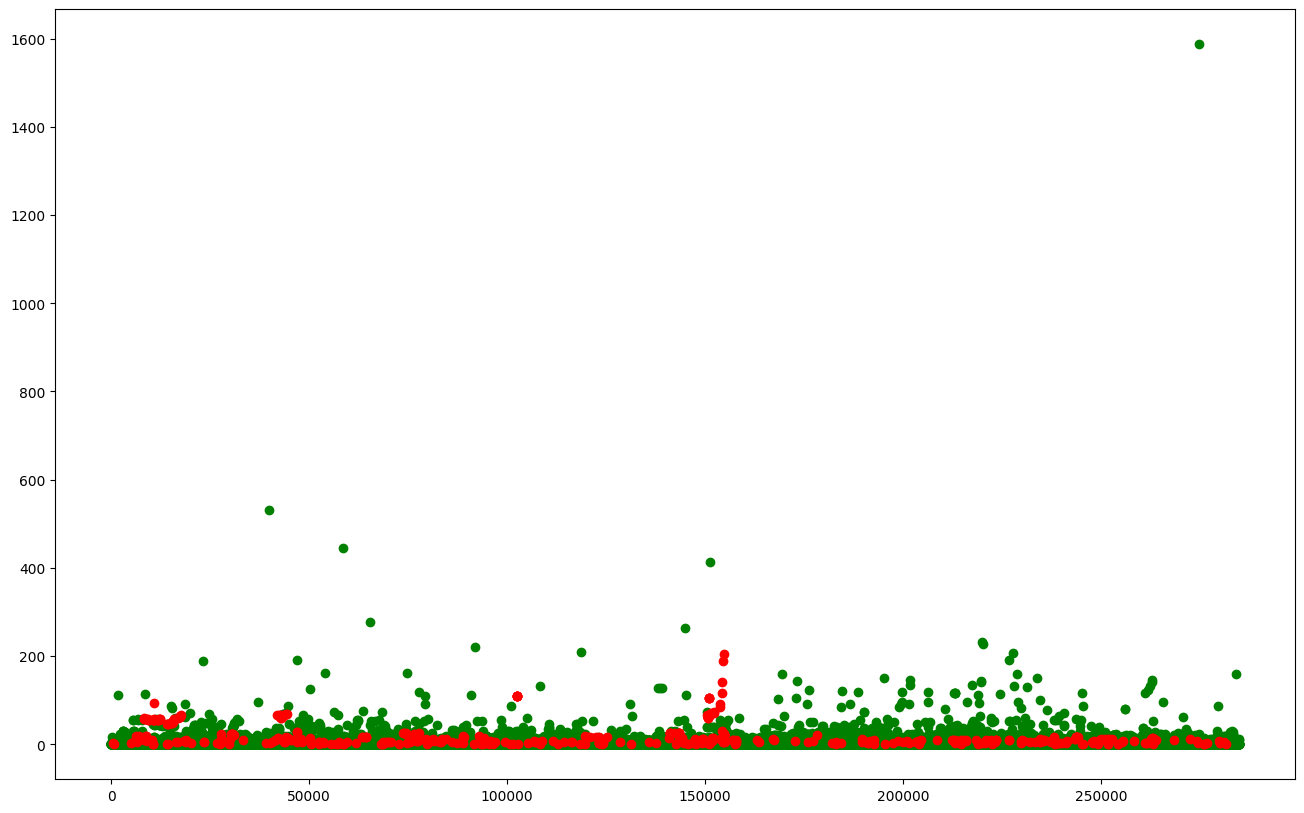

In [22]:
plt.figure(figsize=(16,10))
rng = np.arange(len(errs))
colors = ['g','r'] # green: normal, red: anomaly
for i in [0,1]:
    plt.scatter(rng[(Y==i).reshape(-1)], errs[(Y==i).reshape(-1)], color=colors[i])

In [23]:
Y_cut = Y[errs<10]

In [24]:
## The majority of the reconstruction loss is under 10. We filtering these observations for a better visibility. 
print(Y[errs<10].shape + Y[errs>10].shape)
print(Y[errs<10].shape[0] + Y[errs>10].shape[0])
print (Y.shape)
print (Y_cut.shape)

(282870, 1937)
284807
(284807,)
(282870,)


In [25]:
Y_cut    = Y[errs<10]
errs_cut = errs[errs<10]

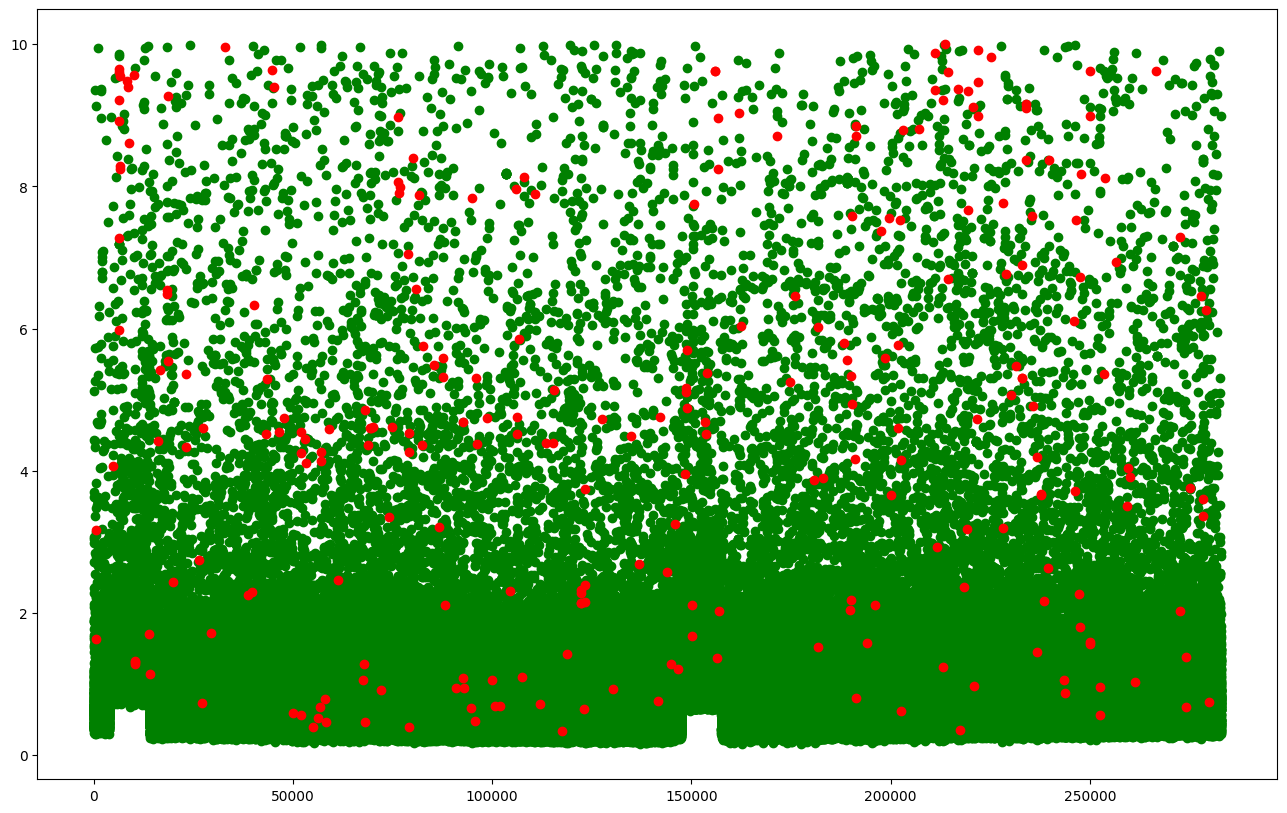

In [26]:
plt.figure(figsize=(16,10))
rng = np.arange(len(errs_cut))
colors = ['g','r'] 
for i in [0,1]:
    plt.scatter(rng[(Y_cut==i).reshape(-1)], errs_cut[(Y_cut==i).reshape(-1)], color=colors[i])

## Exercise 4: finding the right treshold
Find a treshold that identifies at least 130 anomalies correctly with as small number of missclassifications of non-anomalies as possible. 

In [58]:
treshold = 24.5
errs_filtered               = errs[errs>treshold]
Y_filtered                  = Y[errs>treshold] #Y_filtered = Y[errs>treshold,0]
errs_filtered_non_anomalies = errs[errs<=treshold]
Y_filtered_non_anomalies    = Y[errs<=treshold] #Y_filtered_non_anomalies    = Y[errs<=treshold,0]

print("Anomalies in the dataset") # Y_filtered==1
print("   predicted as anomaly:", len(errs_filtered[Y_filtered==1]))
print("   predicted as non-anomaly: ", len(errs_filtered_non_anomalies[Y_filtered_non_anomalies==1]) )
print("Non-anomalies in the dataset") # Y_filtered ==0
print("   predicted as anomaly:", len(errs_filtered[Y_filtered==0]))
print("   predicted as non-anomaly:", len(errs_filtered_non_anomalies[Y_filtered_non_anomalies==0]) )


Anomalies in the dataset
   predicted as anomaly: 130
   predicted as non-anomaly:  362
Non-anomalies in the dataset
   predicted as anomaly: 472
   predicted as non-anomaly: 283843


We can also inspect the confusion matrix:

<Axes: >

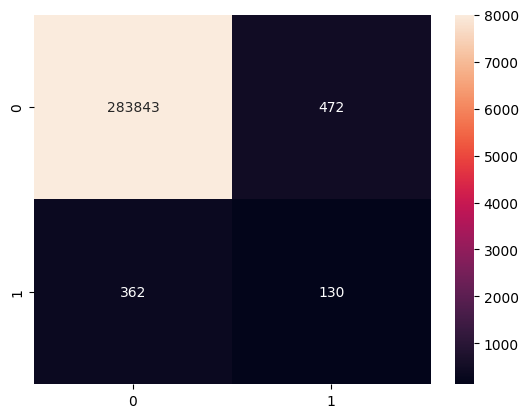

In [59]:
from sklearn.metrics import confusion_matrix
conf=confusion_matrix(Y, errs>treshold)
import seaborn as sns
sns.heatmap(conf, annot=True, vmax=8000, fmt="d")